In [22]:
import json
import pandas as pd
import time
import datetime
import gcsfs
import numpy as np
import gender_guesser.detector as gender
from datetime import date
from google.cloud import storage
from google.cloud import bigquery

from pathlib import Path
import os

PROJ_ROOT = Path().resolve().parent
KEYS_DIR = PROJ_ROOT / 'keys' 
keys = KEYS_DIR / 'Keys for Big Query Storage Admin - PEII.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str(keys)

In [23]:
# Get today's date
today = datetime.datetime.today().date()

# Instantiate bigquery client
client = bigquery.Client()
job_config = bigquery.QueryJobConfig()


In [24]:
# Get processed entrepreneur table from BQ
entrepreneur_query = """
    #standardSQL
    SELECT *
    FROM `peii-242723.entrepreneur_data.processed_entrepreneur_data`
    """

In [25]:
entrepreneur_query_job = client.query(entrepreneur_query, location = 'US')
entrepreneur_result = entrepreneur_query_job.result()

# Creates dataframe of entrepreneur names
entrepreneur_df = entrepreneur_result.to_dataframe()

In [26]:
entrepreneur_df

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id
0,Darron Schall,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,900126,17.0,0.0,0,Ada,Michigan,MI,NaN,None,male,None,None,None
1,Derik Lolli,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,900126,17.0,0.0,0,Ada,Michigan,MI,NaN,None,male,None,None,None
2,Shane O'Donnell,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,900126,17.0,0.0,0,Ada,Michigan,MI,NaN,None,male,None,None,None
3,Blake George,BFile System,7459aecfd94c4419af7e3f4092dc124e,bfile-system,0,25.0,0.0,0,Ray,Michigan,MI,19820.0,220.0,male,None,None,None
4,Jim Bologna,BFile System,7459aecfd94c4419af7e3f4092dc124e,bfile-system,0,25.0,0.0,0,Ray,Michigan,MI,19820.0,220.0,male,None,None,None
5,David Marra,Arialytics,23bd37368acb0d45f7ce6aea87c79306,arialytics,0,10.0,1.0,0,Rye,New York,NY,35620.0,408.0,male,None,None,None
6,Tarek Fadel,Fadel Partners,4445963b62b102bce905535621a393f1,fadel-partners,7000000,100.0,9.0,0,Rye,New York,NY,35620.0,408.0,male,None,None,None
7,John Arenas,Serendipity Labs Coworking,56ef66f279d0df8f9906bd7a95f40e13,serendipity-labs,100297908,100.0,0.0,0,Rye,New York,NY,35620.0,408.0,male,None,None,None
8,Mike Preiner,Solum,6cfc942cc4c2e6b30691eefcc788dccb,solum-2,7833333,17.0,0.0,0,Ames,Iowa,IA,11180.0,218.0,male,None,None,None
9,Justin White,Solum,6cfc942cc4c2e6b30691eefcc788dccb,solum-2,7833333,17.0,0.0,0,Ames,Iowa,IA,11180.0,218.0,male,None,None,None


In [27]:
# Create first name column
for i in entrepreneur_df.index:
    entrepreneur_df.at[i, 'first_name'] = entrepreneur_df.at[i, 'name'].split(' ')[0].lower()

# Query only null values
null = entrepreneur_df[pd.isnull(entrepreneur_df['gender'])]

In [28]:
entrepreneur_df.shape

(38497, 18)

In [30]:
null.shape

(2226, 18)

In [32]:
number_null = entrepreneur_df.shape[0] - null.shape[0]
number_null

36271

In [33]:
# Get only unique names that are female, and aggregate the record number for each name
female_names_query = """
    #standardSQL
    SELECT name, SUM(number) as records
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    WHERE gender = 'F'
    GROUP BY name
    ORDER BY records DESC
    """

female_names_query_job = client.query(female_names_query, location = 'US')
female_names_result = female_names_query_job.result()

# Create dataframe of male names
female_names_df = female_names_result.to_dataframe()

In [34]:
# Takes only the names and turns it into a list
female_names = female_names_df['name'].to_list()
    
# Lowercase
for i in range(len(female_names)):
    female_names[i] = female_names[i].lower()

# Creates a separate list for male names because it is faster to use SQL than iterate through df
male_names_query = """
    #standardSQL
    SELECT name, SUM(number) as records
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    WHERE gender = 'M'
    GROUP BY name
    ORDER BY records DESC
    """

male_names_query_job = client.query(male_names_query,location = 'US')
male_names_result = male_names_query_job.result()

# Create dataframe of male names
male_names_df = male_names_result.to_dataframe()
# Take only the male names and turns it into a list
male_names = male_names_df['name'].to_list()
# Lowercase
for i in range(len(male_names)):
    male_names[i] =  male_names[i].lower()

# Find androgynous names
andro_names = (set(male_names).intersection(female_names))

# Female names not in male list
female_names = set(female_names) - set(male_names)

# Male names not in female list
male_names = set(male_names) - set(female_names)

# Make everything into lists
andro_names = list(andro_names)
female_names = list(female_names)
male_names = list(male_names)

male_names_df = male_names_df.set_index('name')
female_names_df = female_names_df.set_index('name')


In [35]:
count_male = 0
count_female = 0
count_na = 0
femme = []
masc = []

# Sort androgynous names
for name in andro_names:
    name = name.capitalize()
    male_count = male_names_df.loc[name]['records']
    female_count = female_names_df.loc[name]['records']
    total = male_count + female_count
    percentage_male = round(male_count / total, 2)
    percentage_female = round(female_count / total, 2)
    if percentage_male >= 0.667:
        gender_assign = 'M'
        count_male += 1
        masc.append(name.lower())
    elif percentage_female >= 0.667:
        gender_assign = 'F'
        count_female += 1
        femme.append(name.lower())
    else:
        gender_assign = 'N/A'
        count_na += 1

    # x = 10 - len(str(male_count + female_count))
    # y = 10 - len(name)
    #debugging
    #print(name, y*' ', male_count, female_count, x*' ', ' | ', percentage_male, percentage_female, ' | ', gender_assign)

# Combine lists
female_names = female_names + femme
male_names = male_names + masc

# Unidentified names
andro_ = set(andro_names) - set(masc)
andro_ = set(andro_) - set(femme)

In [36]:
# Assign gender from social security data
female_count = 0
male_count = 0
andro_count = 0
na_count = 0

for i in null.index:
    name = null.at[i, 'first_name'].lower()

    if name in female_names:
        entrepreneur_df.at[i, 'gender'] = 'f'
        female_count += 1

    elif name in male_names:
        entrepreneur_df.at[i, 'gender'] = 'm'
        male_count += 1

    elif name in andro_:
        entrepreneur_df.at[i, 'gender'] = 'andro'
        andro_count += 1

    else:
        entrepreneur_df.at[i, 'gender'] = 'unknown'
        na_count += 1

# Use the gender guesser
d = gender.Detector()

# Create additional checks for gender
additional_female_names = [
    'Alika',
    'Ama',
    'Cibelle',
    'Kimberlina',
    'Leathia',
    'Shiri',
    'Lavena',
    'Tanjila',
    'Holley',
    'Anie',
    'Dionna',
    'Shanel',
    'Lakshya',
    'Shenda',
    'Madelena',
    'Kerranna',
    'Piya',
    'Paria',
    'Ylianna',
    'Ankita',
    'Isha',
    'Gabby',
    'Anjelika',
    'Nitha',
    'Adena',
    'Sumayah',
    'Louisea',
    'Cymphonique',
    'Charlyn',
    'Tari',
    'Graceann',
    'Kalia',
    'Annmarie',
    'Saira',
]
additional_male_names = [
    'Deward',
    'Omkar',
    'Rohit',
    'Mohit',
    'Vik',
    'Vishal',
    'Obed',
    'Ashwin',
    'Ozel',
    'Umed',
    'Demetri',
    'Tripp',
    'Jean-Marc',
    'Laszlo',
    'Allon',
    'Rishi'
    'Francois',
    'Clarkson',
    'Siddharth',
    'Sidharth',
    'Anup',
    'Anoop',
    'Zac',
    'Andras',
    'Abhishek',
    'Dil-Domine',
    'Varun',
    'Abhinav',
    'Chaitanya',
    'Rishi',
    'Raghu',
    'Anurag',
    'Akshay',
    'Gaurav',
    'Kunal',
]

# Create column 'female'
entrepreneur_df['female'] = 0

# Collect indices of female and androgynous names, and mark them as female
female_names = []
andy_names = []
unk_names = []

count_female = 0
count_andy = 0
count_unk = 0

for i in entrepreneur_df.index:
    name = entrepreneur_df.at[i, 'first_name']
    if d.get_gender(name) == 'female':
        female_names.append([i, name])
        entrepreneur_df.at[i, 'female'] = 1
        count_female += 1
    elif d.get_gender(name) == 'mostly_female':
        female_names.append([i, name])
        entrepreneur_df.at[i, 'female'] = 1
        count_female += 1
    elif d.get_gender(name) == 'andy':
        andy_names.append([i, name])
        count_andy += 1
    elif d.get_gender(name) == 'unknown':
        if name in additional_female_names:
            female_names.append([i, name])
            entrepreneur_df.at[i, 'female'] = 1
            count_female += 1
        elif name in additional_male_names:
            pass
        else:
            unk_names.append([i, name])
            count_unk += 1
            

for i in entrepreneur_df.index:
    # Over-ride the gender_guesser with the social security data
    if entrepreneur_df.at[i, 'gender'] == 'f' and entrepreneur_df.at[i, 'female'] == 0:
        entrepreneur_df.at[i, 'gender'] = 'Female'
    if entrepreneur_df.at[i, 'gender'] == 'm' and entrepreneur_df.at[i, 'female'] == 1:
        entrepreneur_df.at[i, 'gender'] = 'Male'

    # Assign female if both agree, and male if both agree
    if entrepreneur_df.at[i, 'gender'] == 'f' and entrepreneur_df.at[i, 'female'] == 1:
        entrepreneur_df.at[i, 'gender'] = 'Female'
    if entrepreneur_df.at[i, 'gender'] == 'm' and entrepreneur_df.at[i, 'female'] == 0:
        entrepreneur_df.at[i, 'gender'] = 'Male'



In [37]:
entrepreneur_df['ent'] = 1

In [40]:
for i in entrepreneur_df.index:
    if entrepreneur_df.at[i, 'gender'] == 'Female':
        entrepreneur_df.at[i, 'female'] = 1
    if entrepreneur_df.at[i, 'gender'] == 'female':
        entrepreneur_df.at[i, 'female'] = 1

In [39]:
entrepreneur_df.gender.value_counts()

male       31865
female      4406
unknown     1446
Male         619
Female       161
Name: gender, dtype: int64

In [1]:
#overall female percentage
3921/31693

0.12371817120499795

In [43]:
ent_csa_df = entrepreneur_df.groupby('csa_code').sum()

In [279]:
ent_csa_df['percent_womxn'] = ent_csa_df['female'] / ent_csa_df['ent']

In [280]:
ent_csa_df

,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womyn,funding_low_agg,percent_womxn
csa_code,,,,,,,,,,
104.0,33393066,339.0,26.0,0,222180.0,4,21,0.190476,0,0.190476
106.0,420764341,2172.0,43.0,0,1365720.0,5,68,0.073529,0,0.073529
107.0,45724469,50.0,7.0,0,11020.0,1,1,1.000000,0,1.000000
108.0,0,50.0,3.0,0,11100.0,0,1,0.000000,0,0.000000
120.0,181876326,492.0,3.0,0,248820.0,2,21,0.095238,0,0.095238
122.0,6292916004,47316.0,807.0,17,7906920.0,69,647,0.106646,0,0.106646
140.0,83352804,359.0,0.0,0,242280.0,5,18,0.277778,0,0.277778
142.0,147688533,1623.0,25.0,0,649540.0,4,47,0.085106,0,0.085106
144.0,24570101,1219.0,4.0,0,168240.0,1,12,0.083333,0,0.083333


In [281]:
ent_csa_df.iloc[124, :]

funding            6085000.0
jobs_created            30.0
patents                  4.0
ipo                      0.0
cbsa_code           239340.0
female                   1.0
ent                      5.0
percent_womyn            0.2
funding_low_agg          0.0
percent_womxn            0.2
Name: 554.0, dtype: float64

In [282]:
ent_csa_df.iloc[126, :]

funding            25000.0
jobs_created          10.0
patents                2.0
ipo                    0.0
cbsa_code          99320.0
female                 0.0
ent                    2.0
percent_womyn          0.0
funding_low_agg        0.0
percent_womxn          0.0
Name: 566.0, dtype: float64

In [283]:
len(list(ent_csa_df.index))

128

In [284]:
ent_csa_df

,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womyn,funding_low_agg,percent_womxn
csa_code,,,,,,,,,,
104.0,33393066,339.0,26.0,0,222180.0,4,21,0.190476,0,0.190476
106.0,420764341,2172.0,43.0,0,1365720.0,5,68,0.073529,0,0.073529
107.0,45724469,50.0,7.0,0,11020.0,1,1,1.000000,0,1.000000
108.0,0,50.0,3.0,0,11100.0,0,1,0.000000,0,0.000000
120.0,181876326,492.0,3.0,0,248820.0,2,21,0.095238,0,0.095238
122.0,6292916004,47316.0,807.0,17,7906920.0,69,647,0.106646,0,0.106646
140.0,83352804,359.0,0.0,0,242280.0,5,18,0.277778,0,0.277778
142.0,147688533,1623.0,25.0,0,649540.0,4,47,0.085106,0,0.085106
144.0,24570101,1219.0,4.0,0,168240.0,1,12,0.083333,0,0.083333


In [287]:
top_100 = ent_csa_df[ent_csa_df.ent >= 100]

In [288]:
top_100

,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womyn,funding_low_agg,percent_womxn
csa_code,,,,,,,,,,
122.0,6292916004,47316.0,807.0,17,7906920.0,69,647,0.106646,0,0.106646
148.0,37672364042,4115758.0,1797.0,155,40174880.0,294,2562,0.114754,0,0.114754
172.0,1180085135,5436.0,158.0,4,1975320.0,13,118,0.110169,0,0.110169
176.0,8171193993,36392.0,392.0,12,14619780.0,107,861,0.124274,0,0.124274
178.0,713476804,7442.0,88.0,3,2073940.0,8,121,0.066116,0,0.066116
184.0,864592389,6250.0,208.0,0,2339460.0,14,141,0.099291,0,0.099291
198.0,1342509136,4273.0,14.0,0,2321920.0,8,128,0.062500,0,0.062500
206.0,2938056735,42578.0,289.0,15,7468100.0,34,391,0.086957,0,0.086957
216.0,6395461610,1035906.0,495.0,31,14024800.0,86,786,0.109415,0,0.109415


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x135a50b00>]],
      dtype=object)

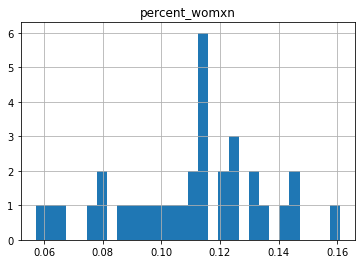

In [289]:
top_100.hist('percent_womxn', bins = 30)

In [290]:
ser = top_100['percent_womxn']

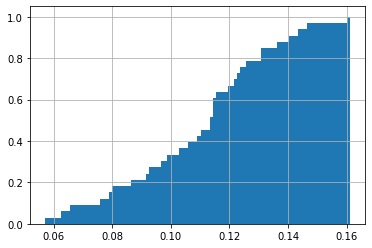

In [57]:
ser.hist(cumulative=True, density=True, bins=100)

In [63]:
np.percentile(np.cumsum(ser), 0.025)

0.10756409151949729

In [64]:
np.percentile(np.cumsum(ser), 0.975)

0.14244933742113663

In [65]:
#oh this is how you do it

In [73]:
# looking up different names

In [66]:
#for i in ent_csa_df.index:
unk_csa_df = 

104.0
106.0
107.0
108.0
120.0
122.0
140.0
142.0
144.0
146.0
147.0
148.0
150.0
160.0
162.0
163.0
168.0
170.0
172.0
174.0
176.0
178.0
184.0
190.0
192.0
194.0
198.0
206.0
209.0
212.0
216.0
218.0
220.0
233.0
238.0
240.0
244.0
258.0
260.0
264.0
266.0
267.0
268.0
272.0
273.0
276.0
277.0
278.0
288.0
290.0
292.0
294.0
296.0
298.0
300.0
304.0
310.0
312.0
313.0
315.0
318.0
320.0
324.0
332.0
336.0
339.0
340.0
348.0
350.0
352.0
356.0
357.0
365.0
366.0
368.0
370.0
372.0
376.0
378.0
388.0
390.0
396.0
400.0
406.0
408.0
412.0
416.0
420.0
422.0
425.0
426.0
428.0
429.0
430.0
438.0
440.0
444.0
446.0
448.0
450.0
452.0
456.0
462.0
464.0
466.0
468.0
472.0
474.0
476.0
480.0
482.0
484.0
488.0
500.0
508.0
515.0
518.0
524.0
532.0
534.0
536.0
538.0
545.0
548.0
554.0
556.0
566.0
none


In [69]:
unk_df = entrepreneur_df[(entrepreneur_df['gender'] == 'unknown') & (entrepreneur_df['csa_code'] == '176.0')]
unk_names = list(unk_df.index)

In [78]:
percent_womyn_here = ent_csa_df.at['176.0', 'percent_womxn']

In [79]:
percent_womyn_here

0.12427409988385599

In [76]:
s = np.random.uniform(0,1,len(unk_names))

In [77]:
s

array([0.45403897, 0.08224861, 0.40190437, 0.33690853, 0.87248995,
       0.57494109, 0.10332329, 0.75132196, 0.53026238, 0.33223952,
       0.96330293, 0.14621743, 0.15021303, 0.38616965, 0.45865952,
       0.67282786, 0.42470282, 0.00329849, 0.31383984, 0.06630702,
       0.95501974])

In [97]:
np.sum(funding_list)

262416220

In [118]:
unk_df.at[6433, 'name']

'Mangesh Bhamkar'

In [128]:
len(unk_names)

21

In [129]:
len(s)

21

In [170]:
ent_csa_df.index

Index(['104.0', '106.0', '107.0', '108.0', '120.0', '122.0', '140.0', '142.0',
       '144.0', '146.0',
       ...
       '532.0', '534.0', '536.0', '538.0', '545.0', '548.0', '554.0', '556.0',
       '566.0', 'none'],
      dtype='object', name='csa_code', length=128)

In [179]:
ent_csa_df['funding_low_agg'] = 0

In [180]:
ent_csa_df

,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womyn,funding_low_agg
csa_code,,,,,,,,,
104.0,33393066,339.0,26.0,0,222180.0,4,21,0.190476,0
106.0,420764341,2172.0,43.0,0,1365720.0,5,68,0.073529,0
107.0,45724469,50.0,7.0,0,11020.0,1,1,1.000000,0
108.0,0,50.0,3.0,0,11100.0,0,1,0.000000,0
120.0,181876326,492.0,3.0,0,248820.0,2,21,0.095238,0
122.0,6292916004,47316.0,807.0,17,7906920.0,69,647,0.106646,0
140.0,83352804,359.0,0.0,0,242280.0,5,18,0.277778,0
142.0,147688533,1623.0,25.0,0,649540.0,4,47,0.085106,0
144.0,24570101,1219.0,4.0,0,168240.0,1,12,0.083333,0


In [314]:
ent_csa_df['funding_high_agg'] = 0
ent_csa_df['funding_low_agg'] = 0
ent_csa_df['funding_mean'] = 0
ent_csa_df['jobs_high_agg'] = 0
ent_csa_df['jobs_low_agg'] = 0
ent_csa_df['jobs_mean'] = 0
ent_csa_df['IP_high_agg'] = 0
ent_csa_df['IP_low_agg'] = 0
ent_csa_df['IP_mean'] = 0

In [316]:
percent_womxn_here = ent_csa_df.at['176.0', 'percent_womxn']

In [317]:
unk_df = entrepreneur_df[(entrepreneur_df['gender'] == 'unknown') & (entrepreneur_df['csa_code'] == '176.0')]
unk_names = list(unk_df.index)

In [345]:
funding_hist = []
job_hist = []
patents_hist = []

for i in range(10000):
    funding_list = []
    job_list = []
    patents_list = []
    s = np.random.uniform(0,1,len(unk_names))
    for i in range(len(s)):
        if s[i] < percent_womyn_here:
            index = unk_names[i]
            #print('index ' + str(index))
            funding_list.append(entrepreneur_df.at[index, 'funding'])
            job_list.append(entrepreneur_df.at[index, 'jobs_created'])
            patents_list.append(entrepreneur_df.at[index, 'patents'])
        funding_aggregate = np.sum(funding_list)
        job_aggregate = np.sum(job_list)
        patents_aggregate = np.sum(funding_list)
    #print(funding_aggregate)
    funding_hist.append(funding_aggregate)
    job_hist.append(job_aggregate)
    patents_hist.append(patents_aggregate)
    

In [350]:
def closest(lst, K):     
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i] - K))]

In [354]:
#takes the lists of rounds and returns mean, highs and lows
def normalize_and_append(lst):
    count, bins, ignored = plt.hist(lst, bins = 30)
    norm = [float(i)/sum(count) for i in count]
    bins = bins[:-1]
    # Normalize
    x = np.cumsum(norm)
    iterate = [[x[k], bins[k]] for k in range(30)]
    
    lower_limit = closest(x, 0.025)
    upper_limit = closest(x, 0.975)
    
    for i in range(len(iterate)):
    #print(np.round(iterate[i][0], 2))
        if iterate[i][0] == lower_limit:
            lower_conf = iterate[i][1]
        
        if iterate[i][0] == upper_limit:
            upper_conf = iterate[i][1]
    
    return(upper_conf, lower_conf, np.mean(lst))

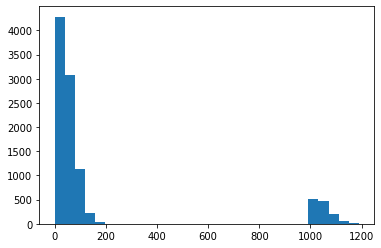

In [361]:
upper_conf, lower_conf, mean = normalize_and_append(job_hist)

In [362]:
ent_csa_df.at['176.0', 'jobs_high_agg'] = upper_conf
ent_csa_df.at['176.0', 'jobs_low_agg'] = lower_conf
ent_csa_df.at['176.0', 'jobs_mean'] = np.mean(job_hist)

In [383]:
def add_variable_aggregates(df):
    ent_csa_df = df.groupby('csa_code').sum()
    ent_csa_df['percent_womxn'] = ent_csa_df['female'] / ent_csa_df['ent']
    csa_list = list(ent_csa_df.index)
    ent_csa_df['funding_high_agg'] = 0
    ent_csa_df['funding_low_agg'] = 0
    ent_csa_df['funding_mean'] = 0
    ent_csa_df['jobs_high_agg'] = 0
    ent_csa_df['jobs_low_agg'] = 0
    ent_csa_df['jobs_mean'] = 0
    ent_csa_df['IP_high_agg'] = 0
    ent_csa_df['IP_low_agg'] = 0
    ent_csa_df['IP_mean'] = 0
    
    for csa in csa_list:
        new_df = df[(df['gender'] == 'unknown') & (df['csa_code'] == csa)]
        unk_names = list(new_df.index)
        percent_womxn_here = ent_csa_df.at[csa, 'percent_womxn']
        #print(percent_womxn_here)
        
        for each in unk_names:
            #print(new_df.at[i, 'funding'])
            funding_hist = []
            job_hist = []
            patents_hist = []
            
            for j in range(1000):
                funding_list = []
                job_list = []
                patents_list = []
                s = np.random.uniform(0, 1, len(unk_names))
                
                for i in range(len(s)):
                    if s[i] < percent_womxn_here:
                        index = unk_names[i]
                        #print('index ' + str(index))
                        funding_list.append(entrepreneur_df.at[index, 'funding'])
                    funding_aggregate = np.sum(funding_list)
                #print(funding_aggregate)
                funding_hist.append(funding_aggregate)
                
        fnd_upper_conf, fnd_lower_conf, fnd_mean = normalize_and_append(funding_hist)
            
        ent_csa_df.at[csa, 'funding_high_agg'] = fnd_upper_conf
        ent_csa_df.at[csa, 'funding_low_agg'] = fnd_lower_conf
        ent_csa_df.at[csa, 'funding_mean'] = fnd_mean
        
#         ent_csa_df.at[csa, 'funding_high_agg'] = fnd_upper_conf
#         ent_csa_df.at[csa, 'funding_low_agg'] = fnd_lower_conf
#         ent_csa_df.at[csa, 'funding_mean'] = fnd_mean
        
    return(ent_csa_df)

In [374]:
csa_220 = entrepreneur_df[entrepreneur_df['csa_code'] == '220.0']

In [ ]:
    ent_csa_df = entrepreneur_df.groupby('csa_code').sum()
    ent_csa_df['percent_womxn'] = ent_csa_df['female'] / ent_csa_df['ent']
    csa_list = list(ent_csa_df.index)
    ent_csa_df['funding_high_agg'] = 0
    ent_csa_df['funding_low_agg'] = 0
    ent_csa_df['funding_mean'] = 0
    ent_csa_df['jobs_high_agg'] = 0
    ent_csa_df['jobs_low_agg'] = 0
    ent_csa_df['jobs_mean'] = 0
    ent_csa_df['IP_high_agg'] = 0
    ent_csa_df['IP_low_agg'] = 0
    ent_csa_df['IP_mean'] = 0

In [404]:
entrepreneur_df.columns

Index(['name', 'company_name', 'crunchbase_uuid', 'crunchbase_permalink',
       'funding', 'jobs_created', 'patents', 'ipo', 'city', 'state',
       'state_abbrev', 'cbsa_code', 'csa_code', 'gender', 'lgbtq',
       'race_ethnicity', 'startout_id', 'first_name', 'female', 'ent'],
      dtype='object')

In [403]:
def add_variable_aggregates2(df, csa_code):
    
    unk_df = df[(df['gender'] == 'unknown')]
    unk_names = list(unk_df.index)
    percent_womxn_here = ent_csa_df.at[csa_code, 'percent_womxn']
    #print(percent_womxn_here)
        
    #for each in unk_names:
    #print(new_df.at[i, 'funding'])
    funding_hist = []
    job_hist = []
    patents_hist = []
            
    for j in range(1000):
        funding_list = []
        job_list = []
        patents_list = []
        s = np.random.uniform(0, 1, len(unk_names))
                
        for i in range(len(s)):
            if s[i] < percent_womxn_here:
                index = unk_names[i]
                #print('index ' + str(index))
                funding_list.append(entrepreneur_df.at[index, 'funding'])
                job_list.append(entrepreneur_df.at[index, 'jobs_created'])
                #print(patents_list)
                patents_list.append(entrepreneur_df.at[index, 'patents'])
            funding_aggregate = np.sum(funding_list)
            jobs_aggregate = np.sum(job_list)
            patents_aggregate = np.sum(patents_list)
        #print(funding_aggregate)
        funding_hist.append(funding_aggregate)
        job_hist.append(job_aggregate)
        patents_hist.append(funding_aggregate)
                
    fnd_upper_conf, fnd_lower_conf, fnd_mean = normalize_and_append(funding_hist)
    jobs_upper_conf, jobs_lower_conf, jobs_mean = normalize_and_append(job_hist)
    patents_upper_conf, patents_lower_conf, patents_mean = normalize_and_append(patents_hist)
            
    ent_csa_df.at[csa_code, 'funding_high_agg'] = fnd_upper_conf
    ent_csa_df.at[csa_code, 'funding_low_agg'] = fnd_lower_conf
    ent_csa_df.at[csa_code, 'funding_mean'] = fnd_mean
        
    ent_csa_df.at[csa_code, 'jobs_high_agg'] = jobs_upper_conf
    ent_csa_df.at[csa_code, 'jobs_low_agg'] = jobs_lower_conf
    ent_csa_df.at[csa_code, 'jobs_mean'] = jobs_mean
        
    ent_csa_df.at[csa_code, 'jobs_high_agg'] = jobs_upper_conf
    ent_csa_df.at[csa_code, 'jobs_low_agg'] = jobs_lower_conf
    ent_csa_df.at[csa_code, 'jobs_mean'] = jobs_mean
        
    return(ent_csa_df)

KeyboardInterrupt: 

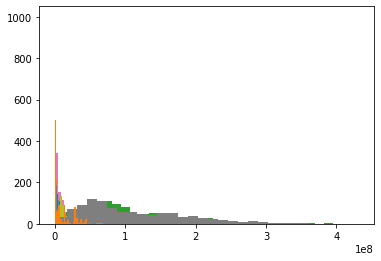

In [384]:
add_variable_aggregates(entrepreneur_df)

In [385]:
csa_220 = entrepreneur_df[entrepreneur_df['csa_code'] == '220.0']

In [387]:
csa_148 = entrepreneur_df[entrepreneur_df['csa_code'] == '148.0']

In [410]:
csa_312 = entrepreneur_df[entrepreneur_df['csa_code'] == '312.0']

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womyn,funding_low_agg,percent_womxn,funding_high_agg,funding_mean,jobs_high_agg,jobs_low_agg,jobs_mean,IP_high_agg,IP_low_agg,IP_mean
csa_code,,,,,,,,,,,,,,,,,,
104.0,33393066,339.0,26.0,0,222180.0,4,21,0.190476,0,0.190476,0,0,0,0,0,0,0,0
106.0,420764341,2172.0,43.0,0,1365720.0,5,68,0.073529,0,0.073529,0,0,0,0,0,0,0,0
107.0,45724469,50.0,7.0,0,11020.0,1,1,1.000000,0,1.000000,0,0,0,0,0,0,0,0
108.0,0,50.0,3.0,0,11100.0,0,1,0.000000,0,0.000000,0,0,0,0,0,0,0,0
120.0,181876326,492.0,3.0,0,248820.0,2,21,0.095238,0,0.095238,0,0,0,0,0,0,0,0
122.0,6292916004,47316.0,807.0,17,7906920.0,69,647,0.106646,0,0.106646,0,0,0,0,0,0,0,0
140.0,83352804,359.0,0.0,0,242280.0,5,18,0.277778,0,0.277778,0,0,0,0,0,0,0,0
142.0,147688533,1623.0,25.0,0,649540.0,4,47,0.085106,0,0.085106,0,0,0,0,0,0,0,0
144.0,24570101,1219.0,4.0,0,168240.0,1,12,0.083333,0,0.083333,0,0,0,0,0,0,0,0


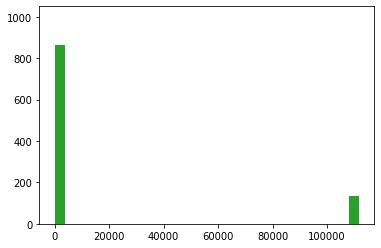

In [411]:
add_variable_aggregates2(csa_312, '312.0')

In [406]:
csa_148['patents']

265       5.0
266       5.0
267       0.0
268      15.0
269       0.0
270       0.0
271       0.0
272       4.0
273       1.0
406       0.0
407       0.0
408      11.0
801       1.0
802       1.0
803       0.0
809       8.0
810       0.0
811       0.0
2018      0.0
2019      0.0
2020      0.0
2021      0.0
2022      0.0
2023      0.0
2024      0.0
2025      0.0
2026      0.0
2027      0.0
2028      0.0
2029      0.0
         ... 
31593     1.0
31594     0.0
31595     0.0
31596     0.0
31597     0.0
31598     0.0
31599     0.0
31600     9.0
31601     0.0
31602     0.0
31603     1.0
31605     0.0
31606     0.0
31607     2.0
31608     2.0
37827     0.0
37828     0.0
37829     0.0
37950     2.0
37951     2.0
37966     0.0
37967     4.0
38132     0.0
38133     0.0
38134     0.0
38135     0.0
38136     0.0
38184     0.0
38185     0.0
38186     0.0
Name: patents, Length: 2562, dtype: float64

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womyn,funding_low_agg,percent_womxn,funding_high_agg,funding_mean,jobs_high_agg,jobs_low_agg,jobs_mean,IP_high_agg,IP_low_agg,IP_mean
csa_code,,,,,,,,,,,,,,,,,,
104.0,33393066,339.0,26.0,0,222180.0,4,21,0.190476,0,0.190476,0,0,0,0,0,0,0,0
106.0,420764341,2172.0,43.0,0,1365720.0,5,68,0.073529,0,0.073529,0,0,0,0,0,0,0,0
107.0,45724469,50.0,7.0,0,11020.0,1,1,1.000000,0,1.000000,0,0,0,0,0,0,0,0
108.0,0,50.0,3.0,0,11100.0,0,1,0.000000,0,0.000000,0,0,0,0,0,0,0,0
120.0,181876326,492.0,3.0,0,248820.0,2,21,0.095238,0,0.095238,0,0,0,0,0,0,0,0
122.0,6292916004,47316.0,807.0,17,7906920.0,69,647,0.106646,0,0.106646,0,0,0,0,0,0,0,0
140.0,83352804,359.0,0.0,0,242280.0,5,18,0.277778,0,0.277778,0,0,0,0,0,0,0,0
142.0,147688533,1623.0,25.0,0,649540.0,4,47,0.085106,0,0.085106,0,0,0,0,0,0,0,0
144.0,24570101,1219.0,4.0,0,168240.0,1,12,0.083333,0,0.083333,0,0,0,0,0,0,0,0


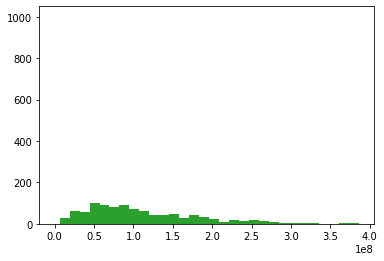

In [405]:
add_variable_aggregates2(csa_148, '148.0')

In [428]:
ent_csa_df.at['321.0']

Index(['104.0', '106.0', '107.0', '108.0', '120.0', '122.0', '140.0', '142.0',
       '144.0', '146.0',
       ...
       '532.0', '534.0', '536.0', '538.0', '545.0', '548.0', '554.0', '556.0',
       '566.0', 'none'],
      dtype='object', name='csa_code', length=128)

In [437]:
ent_csa_df

,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womyn,funding_low_agg,percent_womxn,funding_high_agg,funding_mean,jobs_high_agg,jobs_low_agg,jobs_mean,IP_high_agg,IP_low_agg,IP_mean
csa_code,,,,,,,,,,,,,,,,,,
104.0,33393066,339.0,26.0,0,222180.0,4,21,0.190476,0,0.190476,0,0,0,0,0,0,0,0
106.0,420764341,2172.0,43.0,0,1365720.0,5,68,0.073529,0,0.073529,0,0,0,0,0,0,0,0
107.0,45724469,50.0,7.0,0,11020.0,1,1,1.000000,0,1.000000,0,0,0,0,0,0,0,0
108.0,0,50.0,3.0,0,11100.0,0,1,0.000000,0,0.000000,0,0,0,0,0,0,0,0
120.0,181876326,492.0,3.0,0,248820.0,2,21,0.095238,0,0.095238,0,0,0,0,0,0,0,0
122.0,6292916004,47316.0,807.0,17,7906920.0,69,647,0.106646,0,0.106646,0,0,0,0,0,0,0,0
140.0,83352804,359.0,0.0,0,242280.0,5,18,0.277778,0,0.277778,0,0,0,0,0,0,0,0
142.0,147688533,1623.0,25.0,0,649540.0,4,47,0.085106,0,0.085106,0,0,0,0,0,0,0,0
144.0,24570101,1219.0,4.0,0,168240.0,1,12,0.083333,0,0.083333,0,0,0,0,0,0,0,0


In [445]:
ent_csa_df

,csa_code,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womyn,funding_low_agg,percent_womxn,funding_high_agg,funding_mean,jobs_high_agg,jobs_low_agg,jobs_mean,IP_high_agg,IP_low_agg,IP_mean
0,104.0,33393066,339.0,26.0,0,222180.0,4,21,0.190476,0,0.190476,0,0,0,0,0,0,0,0
1,106.0,420764341,2172.0,43.0,0,1365720.0,5,68,0.073529,0,0.073529,0,0,0,0,0,0,0,0
2,107.0,45724469,50.0,7.0,0,11020.0,1,1,1.000000,0,1.000000,0,0,0,0,0,0,0,0
3,108.0,0,50.0,3.0,0,11100.0,0,1,0.000000,0,0.000000,0,0,0,0,0,0,0,0
4,120.0,181876326,492.0,3.0,0,248820.0,2,21,0.095238,0,0.095238,0,0,0,0,0,0,0,0
5,122.0,6292916004,47316.0,807.0,17,7906920.0,69,647,0.106646,0,0.106646,0,0,0,0,0,0,0,0
6,140.0,83352804,359.0,0.0,0,242280.0,5,18,0.277778,0,0.277778,0,0,0,0,0,0,0,0
7,142.0,147688533,1623.0,25.0,0,649540.0,4,47,0.085106,0,0.085106,0,0,0,0,0,0,0,0
8,144.0,24570101,1219.0,4.0,0,168240.0,1,12,0.083333,0,0.083333,0,0,0,0,0,0,0,0
9,146.0,649704,50.0,0.0,0,42780.0,0,1,0.000000,0,0.000000,0,0,0,0,0,0,0,0


In [444]:
ent_csa_df.reset_index(inplace=True)

In [469]:
for i in ent_csa_df.index:
    if ent_csa_df.at[i, 'csa_code'] == 312:
        print(ent_csa_df.at[i,'funding_high_agg'])
        print(i)

107944
57


In [451]:
diana = 'diana'

In [453]:
diana[:3]

'dia'

In [ ]:
ent_csa_df = ent_csa_df[:127]

In [466]:
for i in ent_csa_df.index:
    csa_code = ent_csa_df.at[i, 'csa_code'] 
    csa_code = csa_code[:3]
    csa_code = int(csa_code)
    ent_csa_df.at[i, 'csa_code'] = csa_code

In [459]:
#verify: 363993779

In [470]:
ent_csa_df.iloc[57,:]

csa_code                    312
funding              1184469436
jobs_created               9670
patents                     176
ipo                           2
cbsa_code           4.03122e+06
female                       21
ent                         143
percent_womyn          0.146853
funding_low_agg          104222
percent_womxn          0.146853
funding_high_agg         107944
funding_mean              15075
jobs_high_agg                50
jobs_low_agg                 49
jobs_mean                    50
IP_high_agg                   0
IP_low_agg                    0
IP_mean                       0
Name: 57, dtype: object

In [462]:
ent_csa_df.at[312,'funding_high_agg']

KeyError: 312

In [412]:
csa_312

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name,female,ent
4415,Lowell Tilzer,TVAX Biomedical,d55f8f6658b05d82acc8fa9e71210de7,tvax-biomedical,6644564,5.0,0.0,0,Lenexa,Kansas,KS,28140.0,312.0,male,None,None,None,lowell,0,1
4416,Gary Wood,TVAX Biomedical,d55f8f6658b05d82acc8fa9e71210de7,tvax-biomedical,6644564,5.0,0.0,0,Lenexa,Kansas,KS,28140.0,312.0,male,None,None,None,gary,0,1
4417,Dana Voien,SleepSafe Drivers,614039647ed04547ea7122676f554abc,sleepsafe-drivers,0,50.0,0.0,0,Lenexa,Kansas,KS,28140.0,312.0,male,None,None,None,dana,0,1
4418,Reggie Chandra,Rhythm Engineering,babd985a360ecaf70939b4762dcd0329,rhythm-engineering,274702,100.0,5.0,0,Lenexa,Kansas,KS,28140.0,312.0,male,None,None,None,reggie,0,1
4419,Mark Kohlrus,Balance Innovations,4105b5ed630b4cb5b57c7f1125bc4ce4,balance-innovations,0,125.0,4.0,0,Lenexa,Kansas,KS,28140.0,312.0,male,None,None,None,mark,0,1
4420,Darren Knipp,Balance Innovations,4105b5ed630b4cb5b57c7f1125bc4ce4,balance-innovations,0,125.0,4.0,0,Lenexa,Kansas,KS,28140.0,312.0,male,None,None,None,darren,0,1
4726,Colleen Dunlap,Stonelock,f35325040f66489eaf99cc4fdf933632,stonelock,3680000,50.0,0.0,0,Olathe,Kansas,KS,28140.0,312.0,female,None,None,None,colleen,1,1
4727,David Stalling,Innara Health,321dbe7deb6c1f6022388970d3da0c7a,innara-health,14930000,50.0,0.0,0,Olathe,Kansas,KS,28140.0,312.0,male,None,None,None,david,0,1
4728,William Whitaker,Metactive Medical,5818cac4cdc4dfead5f484b1e2de1ac4,metactive-medical,6200000,10.0,2.0,0,Olathe,Kansas,KS,28140.0,312.0,male,None,None,None,william,0,1
4729,Tammie Wahaus,ELIAS Animal Health,1dea76b825d943c7ab8dc6423c77eaec,elias-animal-health,3364461,10.0,0.0,0,Olathe,Kansas,KS,28140.0,312.0,female,None,None,None,tammie,1,1


,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womxn,funding_high_agg,funding_low_agg,funding_mean,jobs_high_agg,jobs_low_agg,jobs_mean,IP_high_agg,IP_low_agg,IP_mean
csa_code,,,,,,,,,,,,,,,,,
148.0,37672364042,4115758.0,1797.0,155,40174880.0,294,2562,0.114754,253730122,5128140,109793267,0,0,0,0,0,0


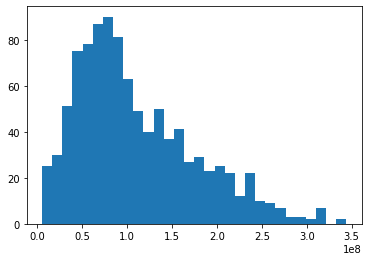

In [388]:
add_variable_aggregates(csa_148, '148.0')

In [391]:
set(entrepreneur_df[entrepreneur_df['csa_code'] == '148.0']['city'])

{'Acton',
 'Andover',
 'Arlington',
 'Barrington',
 'Belmont',
 'Beverly',
 'Bolton',
 'Boston',
 'Boxford',
 'Brookline',
 'Burlington',
 'Cambridge',
 'Canton',
 'Cranston',
 'Danvers',
 'Dover',
 'East Providence',
 'Fitchburg',
 'Framingham',
 'Gloucester',
 'Hardwick',
 'Harvard',
 'Haverhill',
 'Hingham',
 'Holden',
 'Hollis',
 'Holliston',
 'Hopkinton',
 'Hudson',
 'Ipswich',
 'Kingston',
 'Lawrence',
 'Lexington',
 'Lincoln',
 'Lowell',
 'Malden',
 'Manchester',
 'Marblehead',
 'Marlborough',
 'Marshfield',
 'Maynard',
 'Medfield',
 'Medford',
 'Milford',
 'Milton',
 'Nashua',
 'Needham',
 'Newburyport',
 'Newport',
 'Newton',
 'North Andover',
 'North Billerica',
 'North Chelmsford',
 'North Kingstown',
 'North Reading',
 'Norwood',
 'Pawtucket',
 'Peabody',
 'Pelham',
 'Portsmouth',
 'Providence',
 'Quincy',
 'Rochester',
 'Rowley',
 'Salem',
 'Sharon',
 'Somerville',
 'Southborough',
 'Southfield',
 'Stoneham',
 'Sudbury',
 'Tewksbury',
 'Topsfield',
 'Wakefield',
 'Waltham'

In [386]:
top_100

,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womyn,funding_low_agg,percent_womxn
csa_code,,,,,,,,,,
122.0,6292916004,47316.0,807.0,17,7906920.0,69,647,0.106646,0,0.106646
148.0,37672364042,4115758.0,1797.0,155,40174880.0,294,2562,0.114754,0,0.114754
172.0,1180085135,5436.0,158.0,4,1975320.0,13,118,0.110169,0,0.110169
176.0,8171193993,36392.0,392.0,12,14619780.0,107,861,0.124274,0,0.124274
178.0,713476804,7442.0,88.0,3,2073940.0,8,121,0.066116,0,0.066116
184.0,864592389,6250.0,208.0,0,2339460.0,14,141,0.099291,0,0.099291
198.0,1342509136,4273.0,14.0,0,2321920.0,8,128,0.062500,0,0.062500
206.0,2938056735,42578.0,289.0,15,7468100.0,34,391,0.086957,0,0.086957
216.0,6395461610,1035906.0,495.0,31,14024800.0,86,786,0.109415,0,0.109415


,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womxn,funding_high_agg,funding_low_agg,funding_mean,jobs_high_agg,jobs_low_agg,jobs_mean,IP_high_agg,IP_low_agg,IP_mean
csa_code,,,,,,,,,,,,,,,,,
220.0,3945930566,1008148.0,408.0,1,4488040.0,33,290,0.113793,15293226,0,2824763,0,0,0,0,0,0


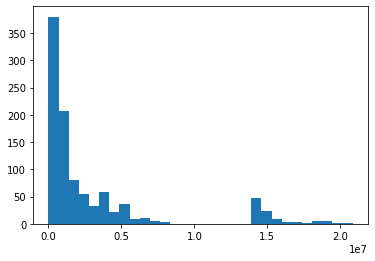

In [381]:
add_variable_aggregates(csa_220)

In [ ]:
add_variable_aggregates(entrepreneur_df)

In [338]:
ent_csa_df.index

Index(['104.0', '106.0', '107.0', '108.0', '120.0', '122.0', '140.0', '142.0',
       '144.0', '146.0',
       ...
       '532.0', '534.0', '536.0', '538.0', '545.0', '548.0', '554.0', '556.0',
       '566.0', 'none'],
      dtype='object', name='csa_code', length=128)

In [341]:
ent_csa_df.at['176.0', 'funding_high_agg'] = upper_conf
ent_csa_df.at['176.0', 'funding_low_agg'] = lower_conf
ent_csa_df.at['176.0', 'funding_mean'] = np.mean(funding_hist)

In [363]:
ent_csa_df.loc['176.0', :]

funding             8.171194e+09
jobs_created        3.639200e+04
patents             3.920000e+02
ipo                 1.200000e+01
cbsa_code           1.461978e+07
female              1.070000e+02
ent                 8.610000e+02
percent_womyn       1.242741e-01
funding_low_agg     0.000000e+00
percent_womxn       1.242741e-01
funding_high_agg    6.258556e+07
funding_mean        1.150451e+07
jobs_high_agg       1.031000e+03
jobs_low_agg        0.000000e+00
jobs_mean           1.700000e+02
IP_high_agg         0.000000e+00
IP_low_agg          0.000000e+00
IP_mean             0.000000e+00
Name: 176.0, dtype: float64

In [301]:
ent_csa_df['percent_womxn']

csa_code
104.0    0.190476
106.0    0.073529
107.0    1.000000
108.0    0.000000
120.0    0.095238
122.0    0.106646
140.0    0.277778
142.0    0.085106
144.0    0.083333
146.0    0.000000
147.0    0.136364
148.0    0.114754
150.0    0.333333
160.0    0.081633
162.0    0.192308
163.0    0.050000
168.0    0.052632
170.0    0.000000
172.0    0.110169
174.0    0.108108
176.0    0.124274
178.0    0.066116
184.0    0.099291
190.0    0.125000
192.0    0.000000
194.0    0.000000
198.0    0.062500
206.0    0.086957
209.0    0.000000
212.0    0.250000
           ...   
448.0    0.500000
450.0    0.121827
452.0    0.000000
456.0    0.111111
462.0    0.250000
464.0    0.116279
466.0    0.000000
468.0    0.250000
472.0    0.131579
474.0    0.000000
476.0    0.076190
480.0    0.000000
482.0    0.057143
484.0    0.114943
488.0    0.114997
500.0    0.120064
508.0    0.000000
515.0    0.000000
518.0    0.173913
524.0    0.000000
532.0    0.062500
534.0    0.000000
536.0    0.121212
538.0    0.058824
5

In [ ]:
norm = [float(i)/sum(count) for i in count]
bins = bins[:-1]
x = np.cumsum(norm)
iterate = [[x[k], bins[k]] for k in range(30)]

In [471]:
x

array([0.046, 0.119, 0.223, 0.337, 0.416, 0.492, 0.533, 0.576, 0.617,
       0.674, 0.736, 0.782, 0.832, 0.871, 0.894, 0.909, 0.923, 0.935,
       0.953, 0.966, 0.974, 0.983, 0.992, 0.993, 0.995, 0.996, 0.996,
       0.998, 0.998, 1.   ])

In [ ]:
funding_hist = []

for i in range(1000):
    funding_list = []
    s = np.random.uniform(0,1,len(unk_names))
    for i in range(len(s)):
        if s[i] < percent_womyn_here:
            index = unk_names[i]
            #print('index ' + str(index))
            funding_list.append(entrepreneur_df.at[index, 'funding'])
        funding_aggregate = np.sum(funding_list)
    print(funding_aggregate)
    funding_hist.append(funding_aggregate)


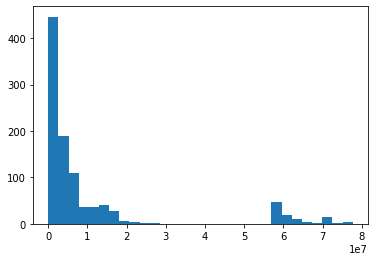

In [310]:
count, bins, ignored = plt.hist(funding_hist, bins = 30)

In [176]:
def add_variable_aggregates(df):
    ent_csa_df = df.groupby('csa_code').sum()
    ent_csa_df['percent_womxn'] = ent_csa_df['female'] / ent_csa_df['ent']
    csa_list = list(ent_csa_df.index)
    
    for csa in csa_list:
        new_df = df[(df['gender'] == 'unknown') & (df['csa_code'] == csa)]
        #print(new_df.index)
        
        for i in new_df.index:
            #print(new_df.at[i, 'funding'])
            funding_hist = []
            
            for i in range(1000):
                funding_list = []
                s = np.random.uniform(0,1,len(unk_names))
                
                for i in range(len(s)):
                    if s[i] < percent_womyn_here:
                        index = unk_names[i]
                        print('index' + str(index))
                        funding_list.append(entrepreneur_df.at[index, 'funding'])
                    funding_aggregate = np.sum(funding_list)
                print(funding_aggregate)
                funding_hist.append(funding_aggregate)
                
                low_end = np.percentile(np.cumsum(funding_hist), 2.5) 

In [177]:
add_variable_aggregates(entrepreneur_df)

Int64Index([241, 28888], dtype='int64')
5702907
2408742
Int64Index([17267, 17280, 26289, 26309], dtype='int64')
26461934
1589999
0
0
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([17909], dtype='int64')
9124995
Int64Index([ 5380,  5447,  5448,  5459,  5471,  5488,  5505,  5506,  5536,
             5538,  5568,  5592,  5593,  5616,  5634,  5644,  5647,  5673,
             5698,  5703,  5704,  5709,  5780,  5783,  5795,  5808,  5818,
             5821,  5822,  5841,  5852,  9099, 16141, 23393, 26737],
           dtype='int64')
8953000
1600000
1600000
110000
0
2150000
20000
20000
1300000
704730
0
400000
400000
14621725
137500
600000
2600000
1133333
1257500
750000
750000
1300000
2000000
53199999
7650000
8333333
2500000
2000000
2000000
0
18725000
2300000
3063481
68500000
1200000
Int64Index([], dtype='int64')
Int64Index([23474], dtype='int64')
4315000
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([  272,   408,  

Int64Index([], dtype='int64')
Int64Index([  398,  4622,  4629,  8233,  8246,  8247, 26246, 29519, 29543,
            29555, 29652, 29671, 29678, 38140],
           dtype='int64')
0
0
400000
683333
0
0
12990241
1000000
13333
50000
50000
1422500
2813000
10500000
Int64Index([963, 11238, 25742, 25779], dtype='int64')
1857143
9116668
1800896
26117333
Int64Index([11562, 25089, 25174, 25195, 25203, 25214], dtype='int64')
126829
36000000
2940000
600000
3250000
15927794
Int64Index([], dtype='int64')
Int64Index([16376, 16469, 16493, 16562, 18053, 18063], dtype='int64')
5900000
1216667
6600000
250000
3333333
0
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([3803, 3828, 3845, 3897, 3922, 8947, 8955, 8969, 8984, 8989], dtype='int64')
36980611
2800160
797500
144410393
0
5825000
593333
2047500
1101000
1101000
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([21372], dtype='int64')
16000000
Int64I

In [415]:
funding_hist = []

for i in range(1000):
    funding_list = []
    s = np.random.uniform(0,1,len(unk_names))
    for i in range(len(s)):
        if s[i] < percent_womyn_here:
            index = unk_names[i]
            #print('index ' + str(index))
            funding_list.append(entrepreneur_df.at[index, 'funding'])
        funding_aggregate = np.sum(funding_list)
    #print(funding_aggregate)
    funding_hist.append(funding_aggregate)

#new_dict
#for i in range(len(unk_names)):
    

#for j in range(1000):
#     funding_list = []
#     for i in range(len(s)):
#         if s[i] < percent_womyn_here:
#             index = unk_names[i]
#             print(i)
#             funding_list.append(entrepreneur_df.at[index, 'funding'])
#         funding_aggregate = np.sum(funding_list)
#     funding_hist.append(funding_aggregate)

In [414]:
unk_names = list(csa_312.index)

In [416]:
funding_list

[274702,
 45000,
 2566667,
 6466667,
 2875000,
 34833333,
 2000000,
 1756000,
 9450000,
 0,
 4318750,
 2082778,
 108333]

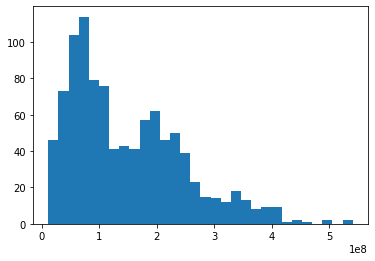

In [417]:
count, bins, ignored = plt.hist(funding_hist, bins = 30)

In [418]:
norm = [float(i)/sum(count) for i in count]
bins = bins[:-1]
x = np.cumsum(norm)
iterate = [[x[k], bins[k]] for k in range(30)]

In [143]:
funding_list

[12500000, 2000000, 1250000, 3555400]

/Users/dhyanna/socos/impact-index/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


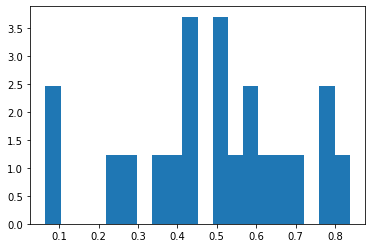

In [309]:
count, bins, ignored = plt.hist(s, 20, normed=True)

In [ ]:
csa_148 = entrepreneur_df[entrepreneur_df['csa_code'] == '148.0']

(array([741., 103.,  35.,   0.,   0.,   0.,   0.,  88.,  27.,   6.]),
 array([       0. ,  7978241.3, 15956482.6, 23934723.9, 31912965.2,
        39891206.5, 47869447.8, 55847689.1, 63825930.4, 71804171.7,
        79782413. ]),
 <a list of 10 Patch objects>)

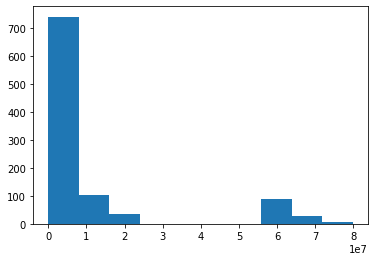

In [188]:
count, bins, ignored = plt.hist(funding_hist, bins = 30)

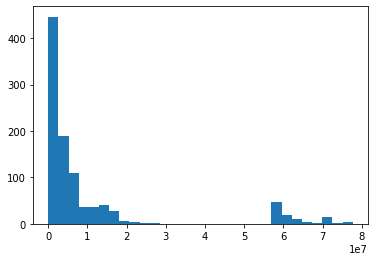

In [304]:
count, bins, ignored = plt.hist(funding_hist, bins = 30)

In [307]:
len(count)

30

In [ ]:
norm = [float(i)/sum(count) for i in count]
bins = bins[:-1]
x = np.cumsum(norm)
iterate = [[x[k], bins[k]] for k in range(30)]

In [203]:
norm = [float(i)/sum(count) for i in count]

In [204]:
bins = bins[:-1]
x = np.cumsum(norm)
iterate = [[x[k], bins[k]] for k in range(30)]

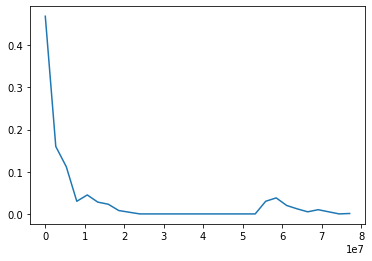

In [205]:
plt.plot(bins, norm)

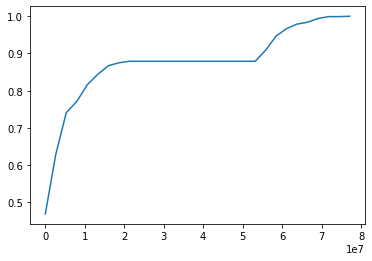

In [207]:
plt.plot(bins, np.cumsum(norm))

In [213]:
x = np.cumsum(norm)

In [266]:
iterate

[[0.469, 0.0],
 [0.629, 2659413.7666666666],
 [0.741, 5318827.533333333],
 [0.771, 7978241.3],
 [0.8160000000000001, 10637655.066666666],
 [0.8440000000000001, 13297068.833333332],
 [0.8670000000000001, 15956482.6],
 [0.8750000000000001, 18615896.366666667],
 [0.8790000000000001, 21275310.133333333],
 [0.8790000000000001, 23934723.9],
 [0.8790000000000001, 26594137.666666664],
 [0.8790000000000001, 29253551.433333334],
 [0.8790000000000001, 31912965.2],
 [0.8790000000000001, 34572378.96666667],
 [0.8790000000000001, 37231792.733333334],
 [0.8790000000000001, 39891206.5],
 [0.8790000000000001, 42550620.266666666],
 [0.8790000000000001, 45210034.03333333],
 [0.8790000000000001, 47869447.8],
 [0.8790000000000001, 50528861.56666666],
 [0.8790000000000001, 53188275.33333333],
 [0.9090000000000001, 55847689.1],
 [0.9470000000000002, 58507102.86666667],
 [0.9670000000000002, 61166516.63333333],
 [0.9790000000000002, 63825930.4],
 [0.9840000000000002, 66485344.166666664],
 [0.9940000000000002,

In [262]:
iterate = [[x[k], bins[k]] for k in range(30)]

In [ ]:
np.percentile()

In [277]:
def closest(lst, K):     
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i] - K))]

In [292]:
np.cumsum(norm)

array([0.469, 0.629, 0.741, 0.771, 0.816, 0.844, 0.867, 0.875, 0.879,
       0.879, 0.879, 0.879, 0.879, 0.879, 0.879, 0.879, 0.879, 0.879,
       0.879, 0.879, 0.879, 0.909, 0.947, 0.967, 0.979, 0.984, 0.994,
       0.999, 0.999, 1.   ])

In [293]:
closest(x, 0.95)

0.9470000000000002

In [420]:
def closest(lst, K):     
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i] - K))]

num_to_get = closest(x, 0.975)

for i in range(len(iterate)):
    #print(np.round(iterate[i][0], 2))
    if iterate[i][0] == num_to_get:
        print(iterate[i][1])
        

363993779.0


In [261]:
[iterate[i] for i in range(len(iterate)) if]

NameError: name 'k' is not defined

In [221]:
np.percentile(bins, 95)

73266849.27166666

In [158]:
funding_hist = sorted(funding_hist)

In [161]:
funding_hist

[0.0,
 0.0,
 0,
 0.0,
 0,
 0.0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0,
 0,
 0.0,
 0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0,
 0,
 0.0,
 0,
 0.0,
 0,
 0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 20000,
 20000,
 20000,
 20000,
 20000,
 20000,
 20000,
 20000,
 20000,
 20000,
 20000,
 20000,
 289513,
 289513,
 289513,
 289513,
 289513,
 289513,
 289513,
 289513,
 289513,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,
 300000,


In [164]:
norm = [float(i)/sum(funding_hist) for i in funding_hist]

In [165]:
norm

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.796565968926125e-06,
 1.796565968926125e-06,
 1.796565968926125e-06,
 1.796565968926125e-06,
 1.796565968926125e-06,
 1.796565968926125e-06,
 1.796565968926125e-06,
 1.796565968926125e-06,
 1.796565968926125e-06,
 1.7965659

(array([741., 103.,  35.,   0.,   0.,   0.,   0.,  88.,  27.,   6.]),
 array([0.        , 0.00071667, 0.00143334, 0.00215002, 0.00286669,
        0.00358336, 0.00430003, 0.0050167 , 0.00573337, 0.00645005,
        0.00716672]),
 <a list of 10 Patch objects>)

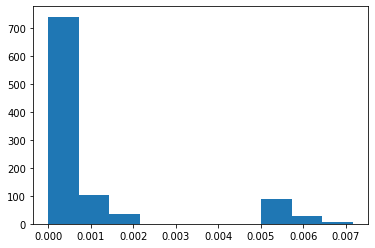

In [178]:
plt.hist(norm)

In [166]:
np.percentile(np.cumsum(funding_hist), 2.5)

0.0

In [168]:
np.percentile(np.cumsum(norm), 97.5)

0.8432598467917712

In [242]:
entrepreneur_df[entrepreneur_df['csa_code'] == '422.0']

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name,female,ent
8696,Tim Arnold,Fyre,80396b1daa7799ec11c36ffbe2b336ce,fyre,0,50.0,1.0,0,Orlando,Florida,FL,36740.0,422.0,male,None,None,None,tim,0,1
8697,Sean Christiansen,Garmor,011d5d9b1246b025f086c6abd4dfad8b,garmor,150000,5.0,1.0,0,Orlando,Florida,FL,36740.0,422.0,male,None,None,None,sean,0,1
8698,Anastasia Canavan,Garmor,011d5d9b1246b025f086c6abd4dfad8b,garmor,150000,5.0,1.0,0,Orlando,Florida,FL,36740.0,422.0,female,None,None,None,anastasia,1,1
8699,Brian Blackburn,Xymogen,682241052dc38efa124ec4fb9a4b1735,xymogn,4200000,1000.0,0.0,0,Orlando,Florida,FL,36740.0,422.0,male,None,None,None,brian,0,1
8700,Christopher Cooper,FanHero,1bfbc0b1c5012e55b07cdc55a62a93a8,fanhero,2750000,25.0,0.0,0,Orlando,Florida,FL,36740.0,422.0,male,None,None,None,christopher,0,1
8701,Peer Snoep,FanHero,1bfbc0b1c5012e55b07cdc55a62a93a8,fanhero,2750000,25.0,0.0,0,Orlando,Florida,FL,36740.0,422.0,male,None,None,None,peer,0,1
8702,Humberto Farias,FanHero,1bfbc0b1c5012e55b07cdc55a62a93a8,fanhero,2750000,25.0,0.0,0,Orlando,Florida,FL,36740.0,422.0,male,None,None,None,humberto,0,1
8703,Leonardo Farias,FanHero,1bfbc0b1c5012e55b07cdc55a62a93a8,fanhero,2750000,25.0,0.0,0,Orlando,Florida,FL,36740.0,422.0,male,None,None,None,leonardo,0,1
8704,Chris Ferrante,Kore.ai,d202d6b2a28e4ce95fd766ef6b70f506,kore-ai,0,167.0,0.0,0,Orlando,Florida,FL,36740.0,422.0,male,None,None,None,chris,0,1
8705,Amit Aghara,Kore.ai,d202d6b2a28e4ce95fd766ef6b70f506,kore-ai,0,167.0,0.0,0,Orlando,Florida,FL,36740.0,422.0,male,None,None,None,amit,0,1


In [ ]:
#312.0

In [245]:
ks_df = entrepreneur_df[entrepreneur_df['csa_code'] == '312.0']

In [254]:
new_ks_df = ks_df.groupby('state')

In [260]:
ks_df['city'].value_counts()

Kansas City        58
Overland Park      28
Leawood            24
Prairie Village     7
Lenexa              6
Missouri City       5
Olathe              5
Mission             4
Lawrence            4
Liberty             1
Basehor             1
Name: city, dtype: int64

In [256]:
set(ks_df['state'])

{'Kansas', 'Missouri'}

In [257]:
set(ks_df['city'])

{'Basehor',
 'Kansas City',
 'Lawrence',
 'Leawood',
 'Lenexa',
 'Liberty',
 'Mission',
 'Missouri City',
 'Olathe',
 'Overland Park',
 'Prairie Village'}

In [312]:
entrepreneur_df[entrepreneur_df['csa_code'] == '312.0']['city'].value_counts()

Kansas City        58
Overland Park      28
Leawood            24
Prairie Village     7
Lenexa              6
Missouri City       5
Olathe              5
Mission             4
Lawrence            4
Liberty             1
Basehor             1
Name: city, dtype: int64

In [ ]:
#408.0

In [225]:
top_100.sort_values(by = 'percent_womyn', ascending = False)

,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womyn
csa_code,,,,,,,,
422.0,665124899,6234.0,144.0,1,4189440.0,19,118,0.161017
312.0,1184469436,9670.0,176.0,2,4031220.0,21,143,0.146853
408.0,83378248241,1245572.0,2623.0,76,179481460.0,732,5087,0.143896
370.0,3294369683,1021333.0,306.0,11,15589320.0,66,469,0.140725
332.0,1781996292,1203426.0,66.0,15,3488940.0,16,117,0.136752
472.0,525098704,7758.0,94.0,0,4693320.0,15,114,0.131579
348.0,35203586743,127169.0,2146.0,69,84441680.0,354,2701,0.131063
428.0,4598701968,28771.0,270.0,23,17794280.0,60,476,0.126050
176.0,8171193993,36392.0,392.0,12,14619780.0,107,861,0.124274


In [223]:
ent_csa_df.sort_values(by = 'percent_womyn', ascending = False)

,funding,jobs_created,patents,ipo,cbsa_code,female,ent,percent_womyn,funding_low_agg
csa_code,,,,,,,,,
107.0,45724469,50.0,7.0,0,11020.0,1,1,1.000000,0
267.0,585000,50.0,0.0,0,49160.0,2,2,1.000000,0
356.0,705000,250.0,1.0,0,31420.0,1,1,1.000000,0
448.0,750000,0.0,0.0,0,50600.0,1,2,0.500000,0
320.0,11959000,229.0,3.0,0,292000.0,4,10,0.400000,0
298.0,20552958,618.0,10.0,0,325680.0,4,12,0.333333,0
446.0,20379809,60.0,5.0,0,118260.0,1,3,0.333333,0
150.0,21750000,260.0,0.0,0,43620.0,1,3,0.333333,0
366.0,6007614,100.0,2.0,0,98340.0,1,3,0.333333,0


In [91]:
import matplotlib.pyplot as plt

(array([12.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.00000000e+00, 5.42356787e+06, 1.08471357e+07, 1.62707036e+07,
        2.16942715e+07, 2.71178393e+07, 3.25414072e+07, 3.79649751e+07,
        4.33885430e+07, 4.88121108e+07, 5.42356787e+07, 5.96592466e+07,
        6.50828144e+07, 7.05063823e+07, 7.59299502e+07, 8.13535180e+07,
        8.67770859e+07, 9.22006538e+07, 9.76242217e+07, 1.03047790e+08,
        1.08471357e+08, 1.13894925e+08, 1.19318493e+08, 1.24742061e+08]),
 <a list of 23 Patch objects>)

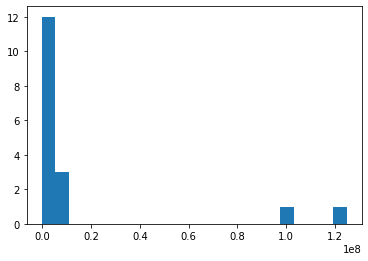

In [92]:
plt.hist(funding_list, bins = 'auto')

In [94]:
np.percentile(np.cumsum(funding_list), 0.025)

903726.5040000001

In [95]:
np.percentile(np.cumsum(funding_list), 0.975)

1040545.656

In [96]:
np.mean(funding_list)

15436248.235294119

In [44]:
new_df = []

In [47]:
for i in entrepreneur_df.index:
    if entrepreneur_df.at[i, 'csa_code'] == '104.0':
        new_df.append(i)

In [54]:
len(new_df)

21

In [51]:
ent_cols = list(entrepreneur_df.columns)

In [146]:
# Creating an empty Dataframe with column names only
csa_df = pd.DataFrame(columns = new_cols)

In [124]:
new_cols = ['name', 'company_name', 'funding', 'jobs_created', 'patents', 'ipo', 'city', 'state','csa_code', 'gender', 'lgbtq']

In [126]:
csa_df

,name,company_name,funding,jobs_created,patents,ipo,city,state,csa_code,gender,lgbtq


In [53]:
# Append rows in Empty Dataframe by adding dictionaries
csa_df = csa_df.append({'User_ID': 23, 'UserName': 'Riti', 'Action': 'Login'}, ignore_index=True)
csa_df = csa_df.append({'User_ID': 24, 'UserName': 'Aadi', 'Action': 'Logout'}, ignore_index=True)
csa_df = csa_df.append({'User_ID': 25, 'UserName': 'Jack', 'Action': 'Login'}, ignore_index=True)

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name,female,ent


In [136]:
ent_df = ent_df.set_index('csa_code') 

In [118]:
entrepreneur_df.columns

Index(['name', 'company_name', 'crunchbase_uuid', 'crunchbase_permalink',
       'funding', 'jobs_created', 'patents', 'ipo', 'city', 'state',
       'state_abbrev', 'cbsa_code', 'csa_code', 'gender', 'lgbtq',
       'race_ethnicity', 'startout_id', 'first_name', 'female', 'ent'],
      dtype='object')

In [127]:
for i in entrepreneur_df.index:
    name = entrepreneur_df.at[i, 'name']
    company_name = entrepreneur_df.at[i, 'company_name']
    funding = entrepreneur_df.at[i, 'funding']
    jobs_created = entrepreneur_df.at[i, 'jobs_created']
    patents = entrepreneur_df.at[i, 'patents']
    ipo = entrepreneur_df.at[i, 'ipo']
    city = entrepreneur_df.at[i, 'city']
    state = entrepreneur_df.at[i, 'state']
    csa_code = entrepreneur_df.at[i, 'csa_code']
    gender = entrepreneur_df.at[i, 'gender']
    lgbtq = entrepreneur_df.at[i, 'lgbtq']
    
    if csa_code == '104.0':
        new_dict = {}
        new_dict['name'] = name
        new_dict['company_name'] = company_name
        new_dict['funding'] = funding
        new_dict['jobs_created'] = jobs_created
        new_dict['patents'] = patents
        new_dict['ipo'] = ipo
        new_dict['csa_code'] = csa_code
        new_dict['gender'] = gender
        print(new_dict)
        csa_df = csa_df.append(new_dict, ignore_index=True)

{'name': 'Steve Wightman', 'funding': 2500000, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Male'}
{'name': 'Shreefal Mehta', 'funding': 5702907, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'unknown'}
{'name': 'Colleen A. Costello', 'funding': 2500000, 'jobs_created': 50.0, 'patents': 4.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Female'}
{'name': 'James W. Peterson', 'funding': 2500000, 'jobs_created': 50.0, 'patents': 4.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Male'}
{'name': 'Dave Geoghegan', 'funding': 1300000, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Male'}
{'name': 'Bob Godgart', 'funding': 1300000, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Male'}
{'name': 'Jay McBain', 'funding': 1300000, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Male'}
{'name': 'David Geoghegan', 'funding': 1300000, 'jobs_cr

In [245]:
#472
csa_472 = entrepreneur_df[entrepreneur_df.csa_code == '472.0']

In [133]:
csa_104 = entrepreneur_df[entrepreneur_df.csa_code == '104.0']

In [300]:
#148.0
csa_148 = entrepreneur_df[entrepreneur_df.csa_code == '104.0']

In [134]:
csa_104

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name,female,ent
238,Steve Wightman,BuildPay,7d9c9b657bc5414c872b33c8b4552b7e,buildpay,2500000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,steve,0,1
239,Shreefal Mehta,PBC Tech,5bf88c84072b463da0ee8e1ef96b2502,pbc-tech,5702907,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,unknown,None,None,None,shreefal,0,1
240,Colleen A. Costello,Vital Vio,8a09a6c7e8619944f9eafdc8b358a3ed,vital-vio,2500000,50.0,4.0,0,Troy,New York,NY,10580.0,104.0,Female,None,None,None,colleen,1,1
241,James W. Peterson,Vital Vio,8a09a6c7e8619944f9eafdc8b358a3ed,vital-vio,2500000,50.0,4.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,james,0,1
244,Dave Geoghegan,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,dave,0,1
245,Bob Godgart,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,bob,0,1
246,Jay McBain,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,jay,0,1
247,David Geoghegan,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,david,0,1
248,Shari Godgart,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,unknown,None,None,None,shari,0,1
249,Karthik Bala,Velan Studios,baa130a5e5b1537cf412b3108f12f7a0,velan-studios,7000000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,karthik,0,1


In [142]:
ent_df.index

Float64Index([104.0, 106.0, 107.0, 108.0, 120.0, 122.0, 140.0, 142.0, 144.0,
              146.0,
              ...
              518.0, 532.0, 534.0, 536.0, 538.0, 545.0, 548.0, 554.0, 556.0,
              566.0],
             dtype='float64', name='csa_code', length=125)

In [143]:
#set index as CSA code as integer, and finding the percent_womyn for each
ent_df.loc[104.0, 'percent_womyn']

0.14285714285714285

In [147]:
csa_104_hist = pd.DataFrame(columns = csa_104.columns)

In [148]:
percent_womyn = ent_df.loc[104.0, 'percent_womyn']

In [151]:
csa_104.reset_index(inplace=True)
csa_104

,level_0,index,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,...,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name,female,ent
0,0,238,Steve Wightman,BuildPay,7d9c9b657bc5414c872b33c8b4552b7e,buildpay,2500000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,steve,0,1
1,1,239,Shreefal Mehta,PBC Tech,5bf88c84072b463da0ee8e1ef96b2502,pbc-tech,5702907,50.0,0.0,0,...,NY,10580.0,104.0,unknown,None,None,None,shreefal,0,1
2,2,240,Colleen A. Costello,Vital Vio,8a09a6c7e8619944f9eafdc8b358a3ed,vital-vio,2500000,50.0,4.0,0,...,NY,10580.0,104.0,Female,None,None,None,colleen,1,1
3,3,241,James W. Peterson,Vital Vio,8a09a6c7e8619944f9eafdc8b358a3ed,vital-vio,2500000,50.0,4.0,0,...,NY,10580.0,104.0,Male,None,None,None,james,0,1
4,4,244,Dave Geoghegan,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,dave,0,1
5,5,245,Bob Godgart,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,bob,0,1
6,6,246,Jay McBain,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,jay,0,1
7,7,247,David Geoghegan,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,david,0,1
8,8,248,Shari Godgart,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,...,NY,10580.0,104.0,unknown,None,None,None,shari,0,1
9,9,249,Karthik Bala,Velan Studios,baa130a5e5b1537cf412b3108f12f7a0,velan-studios,7000000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,karthik,0,1


In [185]:
num_to_sample = np.round(percent_womyn * csa_104.shape[0])
num_to_sample = int(num_to_sample)

In [186]:
length = csa_104.shape[0]
length = int(length)

In [215]:
index_to_sample = np.random.choice(length, num_to_sample, replace=False)

In [218]:
index_to_sample = list(index_to_sample)

In [239]:
for i in index_to_sample:
    name = csa_104.at[i, 'name']
    company_name = csa_104.at[i, 'company_name']
    funding = csa_104.at[i, 'funding']
    jobs_created = csa_104.at[i, 'jobs_created']
    patents = csa_104.at[i, 'patents']
    ipo = csa_104.at[i, 'ipo']
    city = csa_104.at[i, 'city']
    state = csa_104.at[i, 'state']
    csa_code = csa_104.at[i, 'csa_code']
    gender = csa_104.at[i, 'gender']
    lgbtq = csa_104.at[i, 'lgbtq']
    
    if gender == 'unknown':
        new_dict = {}
        new_dict['name'] = name
        new_dict['company_name'] = company_name
        new_dict['funding'] = funding
        new_dict['jobs_created'] = jobs_created
        new_dict['patents'] = patents
        new_dict['ipo'] = ipo
        new_dict['csa_code'] = csa_code
        new_dict['gender'] = gender
        print(new_dict)
        csa_104_hist = csa_104_hist.append(new_dict, ignore_index=True)

{'name': 'Shari Godgart', 'company_name': 'ChannelEyes', 'funding': 1300000, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'unknown'}


In [230]:
csa_104_hist

,name,company_name,funding,jobs_created,patents,ipo,city,state,csa_code,gender,lgbtq
0,Adam Bronte,Furlocity,1545000,10.0,0.0,0,NaN,NaN,104.0,Male,NaN
1,David Geoghegan,ChannelEyes,1300000,50.0,0.0,0,NaN,NaN,104.0,Male,NaN
2,Shari Godgart,ChannelEyes,1300000,50.0,0.0,0,NaN,NaN,104.0,unknown,NaN
3,Adam Bronte,Furlocity,1545000,10.0,0.0,0,NaN,NaN,104.0,Male,NaN


In [210]:
np.random.choice(2, 2, replace=False)

array([1, 0])

In [211]:
csa_df

,name,company_name,funding,jobs_created,patents,ipo,city,state,csa_code,gender,lgbtq


In [235]:
unk_index = list(csa_104[csa_104.gender == 'unknown'].index)

In [243]:
np.round(percent_womyn * len(unk_index))

0.0

In [299]:
csa_472_indivs = csa_472[csa_472.gender == 'unknown']

In [247]:
csa_472_unk = list(csa_472[csa_472.gender == 'unknown'].index)

In [267]:
csa_472_unk

[380, 21467, 25477, 25490, 37828, 37829, 37833]

In [251]:
number_to_sample = int(np.round(percent_womyn * len(csa_472_unk)))

In [252]:
number_to_sample

1

In [268]:
num_list = list(np.random.choice(csa_472_unk, number_to_sample, replace = False))
num_list

[37829]

In [301]:
csa_472

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name,female,ent
370,Tim Colin,Sostena,ccf7444230c2d1af6b083dbb9705a58d,sostena,8100000,NaN,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,tim,0,1
371,Marcus Meadows-Smith,BioConsortia,1de18b32ff0bbce3e1a29c299f9e2fc6,bioconsortia,37000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,marcus,0,1
372,Christina Huben,BioConsortia,1de18b32ff0bbce3e1a29c299f9e2fc6,bioconsortia,37000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Female,None,None,None,christina,1,1
373,Mike G. Hart,Sierra Energy,ea565abdf66945e6973218b3cc481c40,sierra-energy,33000000,NaN,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,mike,0,1
374,Stephen Dueker,Vitalea Science,85dab58de5811b531e80463d6f647a87,vitalea-science,260000,50.0,1.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,stephen,0,1
375,Le Thuy Vuong,Vitalea Science,85dab58de5811b531e80463d6f647a87,vitalea-science,260000,50.0,1.0,0,Davis,California,CA,40900.0,472.0,Female,None,None,None,le,1,1
376,Andrew Sterling,Engage3,73c454252d8c9d47e87a02f89ecf459b,engage3-solution,24000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,andrew,0,1
377,Ken Ouimet,Engage3,73c454252d8c9d47e87a02f89ecf459b,engage3-solution,24000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,ken,0,1
378,Tim Ouimet,Engage3,73c454252d8c9d47e87a02f89ecf459b,engage3-solution,24000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,tim,0,1
379,Daniela Barile,Evolve Biosystems,83e54a307300c95af459892e03217322,evolve-biosystems,69000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Female,None,None,None,daniela,1,1


In [297]:
hist_list = []
for i in range(100000):
    num = list(np.random.choice(csa_472_unk, number_to_sample, replace = False))
    hist_list = hist_list + num

In [302]:
new_hist_list = []
for i in hist_list:
    funding = csa_472.at[i, 'funding']
    new_hist_list.append(funding)

In [314]:
new_hist_list

[250000,
 2139983,
 6800000,
 0,
 65000000,
 69000000,
 65000000,
 6800000,
 250000,
 6800000,
 65000000,
 0,
 6800000,
 2139983,
 69000000,
 0,
 2139983,
 2139983,
 69000000,
 0,
 6800000,
 2139983,
 2139983,
 0,
 65000000,
 65000000,
 250000,
 65000000,
 65000000,
 65000000,
 65000000,
 2139983,
 2139983,
 250000,
 0,
 250000,
 6800000,
 65000000,
 0,
 2139983,
 65000000,
 65000000,
 69000000,
 6800000,
 250000,
 2139983,
 65000000,
 2139983,
 65000000,
 2139983,
 0,
 6800000,
 65000000,
 6800000,
 69000000,
 0,
 65000000,
 6800000,
 6800000,
 65000000,
 250000,
 65000000,
 250000,
 65000000,
 65000000,
 6800000,
 69000000,
 65000000,
 69000000,
 65000000,
 250000,
 2139983,
 250000,
 69000000,
 6800000,
 69000000,
 65000000,
 65000000,
 250000,
 69000000,
 65000000,
 0,
 6800000,
 250000,
 6800000,
 65000000,
 6800000,
 2139983,
 2139983,
 0,
 2139983,
 250000,
 250000,
 65000000,
 65000000,
 0,
 6800000,
 6800000,
 65000000,
 2139983,
 69000000,
 65000000,
 69000000,
 0,
 65000000,

(array([43127.,     0., 14136.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 28486.,
        14251.]),
 array([       0.,  2760000.,  5520000.,  8280000., 11040000., 13800000.,
        16560000., 19320000., 22080000., 24840000., 27600000., 30360000.,
        33120000., 35880000., 38640000., 41400000., 44160000., 46920000.,
        49680000., 52440000., 55200000., 57960000., 60720000., 63480000.,
        66240000., 69000000.]),
 <a list of 25 Patch objects>)

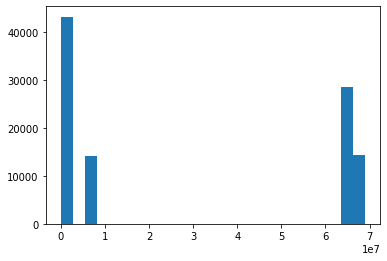

In [316]:
plt.hist(new_hist_list, bins = 'auto')

In [322]:
entrepreneur_df.gender.value_counts()

Male       31693
Female      3921
unknown     2883
Name: gender, dtype: int64

In [365]:
csa_206 = entrepreneur_df[(entrepreneur_df.csa_code == '206.0') & (csa_206.gender == 'unknown')]

In [367]:
num_unk_206 = len(csa_206)

In [369]:
s = np.random.uniform(0,1)
s

0.9463797117078119

In [370]:
percent_womyn_206 = ent_csa_df.at['206.0','percent_womyn']

In [371]:
csa_206_funding_unk = []
for i in csa_206.index:
    if s > percent_womyn_206:
        csa_206_funding_unk.append(csa_206.at[i, 'funding'])

(array([15.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([       0.        ,  9955180.4       , 19910360.8       ,
        29865541.2       , 39820721.6       , 49775902.        ,
        59731082.40000001, 69686262.8       , 79641443.2       ,
        89596623.60000001, 99551804.        ]),
 <a list of 10 Patch objects>)

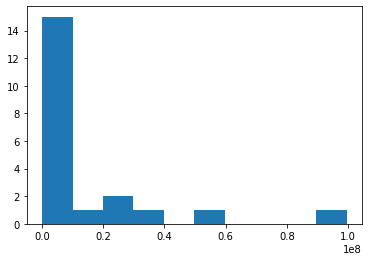

In [372]:
plt.hist(csa_206_funding_unk)

In [378]:
np.histogram(csa_206_funding_unk, bins='auto')

(array([15,  1,  2,  1,  0,  1,  0,  0,  0,  0,  1]),
 array([       0.,  9050164., 18100328., 27150492., 36200656., 45250820.,
        54300984., 63351148., 72401312., 81451476., 90501640., 99551804.]))

In [373]:
values, base = np.histogram(csa_206_funding_unk, bins='auto')

In [377]:
values

array([15,  1,  2,  1,  0,  1,  0,  0,  0,  0,  1])

In [374]:
cumulative = np.cumsum(values)

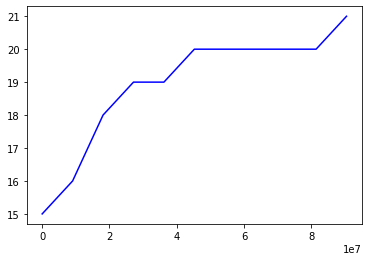

In [375]:
plt.plot(base[:-1], cumulative, c='blue')

In [376]:
cumulative

array([15, 16, 18, 19, 19, 20, 20, 20, 20, 20, 21])

In [ ]:
#for i in range(1000):
for m in range(num_unk_206):
    

In [323]:
#206.0
csa_206 = entrepreneur_df[entrepreneur_df.csa_code == '206.0'] # & entrepreneur_df.gender == 'unknown']

In [326]:
csa_206_unk = csa_206[csa_206.gender == 'unknown']

In [338]:
csa_206_unk_indexes = list(csa_206_unk.index)

In [333]:
ent_csa_df.set_index('csa_code', inplace=True)

In [337]:
percent_womyn_206 = ent_csa_df.at['206.0','percent_womyn']

In [342]:
num_to_sample = int(percent_womyn_206 * len(csa_206_unk_indexes))

In [343]:
# choose the index numbers from ent df randomly
hist_list = []
for i in range(100000):
    num = list(np.random.choice(csa_206_unk_indexes, num_to_sample, replace = False))
    hist_list = hist_list + num

In [344]:
len(hist_list)

100000

In [ ]:
#hist list are the indexes we want to sample from

In [345]:
csa_206_unk_sampled = []
for i in hist_list:
    funding = csa_206_unk.at[i, 'funding']
    csa_206_unk_sampled.append(funding)

In [381]:
import numpy as np
hist, bin_edges = np.histogram(np.random.randint(0,10,100), density=True)
bin_edges
#array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ])

/Users/dhyanna/socos/impact-index/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ])

WARNING:

/Users/dhyanna/socos/impact-index/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

In [382]:
hist

array([0.08888889, 0.11111111, 0.1       , 0.1       , 0.16666667,
       0.12222222, 0.07777778, 0.11111111, 0.15555556, 0.07777778])

In [383]:
np.cumsum(hist)

array([0.08888889, 0.2       , 0.3       , 0.4       , 0.56666667,
       0.68888889, 0.76666667, 0.87777778, 1.03333333, 1.11111111])

In [21]:
np.plt(np.cumsum(hist))

AttributeError: module 'numpy' has no attribute 'plt'

In [385]:
from scipy import stats

In [386]:
stats.cumfreq(csa_206_unk_sampled, numbins=25)

CumfreqResult(cumcount=array([ 28485.,  61883.,  71496.,  71496.,  76262.,  85697.,  85697.,
        85697.,  85697.,  90488.,  90488.,  90488.,  90488.,  95215.,
        95215.,  95215.,  95215.,  95215.,  95215.,  95215.,  95215.,
        95215.,  95215.,  95215., 100000.]), lowerlimit=-2073995.9166666667, binsize=4147991.833333334, extrapoints=0)

([array([ 0.,  0.,  0., 25.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])],
 array([-2073995.91666667, -1451797.14166667,  -829598.36666667,
         -207399.59166667,   414799.18333333,  1036997.95833333,
         1659196.73333333,  2281395.50833333,  2903594.28333333,
         3525793.05833333,  4147991.83333333]),
 <a list of 4 Lists of Patches objects>)

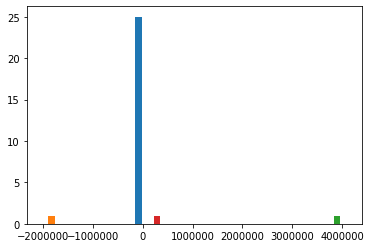

In [387]:
plt.hist(stats.cumfreq(csa_206_unk_sampled, numbins=25))

In [ ]:
>>> hist
#array([ 0.14444444,  0.11111111,  0.11111111,  0.1       ,  0.1       ,
        0.14444444,  0.14444444,  0.08888889,  0.03333333,  0.13333333])
>>> np.cumsum(hist)
#array([ 0.14444444,  0.25555556,  0.36666667,  0.46666667,  0.56666667,
        0.71111111,  0.85555556,  0.94444444,  0.97777778,  1.11111111])

(array([23717.,     0.,     0.,  4768.,  9418.,  4820.,  4843.,  9652.,
            0.,  4665.,     0.,     0.,     0.,     0.,  9613.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  4766.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         9435.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4791.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,  4727.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

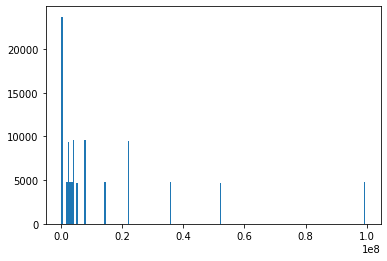

In [346]:
plt.hist(csa_206_unk_sampled, bins = 'auto')

In [351]:
np.mean(csa_206_unk_sampled)

13732125.72039

In [352]:
np.std(csa_206_unk_sampled)

23282948.361306574

In [353]:
13732125 - 23282948

-9550823

In [306]:
np.histogram(new_hist_list, bins = 'auto')

(array([43127,     0, 14136,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 28486, 14251]),
 array([       0.,  2760000.,  5520000.,  8280000., 11040000., 13800000.,
        16560000., 19320000., 22080000., 24840000., 27600000., 30360000.,
        33120000., 35880000., 38640000., 41400000., 44160000., 46920000.,
        49680000., 52440000., 55200000., 57960000., 60720000., 63480000.,
        66240000., 69000000.]))

In [303]:
for i in hist_list:
    funding = csa_472.at[i, 'funding']
    
    new_dict = {}
    new_dict['funding'] = funding
    
    new_df = new_df.append(new_dict, ignore_index=True)

KeyboardInterrupt: 

In [ ]:
new_df.hist('funding', bins = 30)

In [ ]:
new_df.funding.describe()

In [ ]:
new_df.funding.mean()

In [294]:
conf_interval = 1.96 * new_df.funding.std()

In [295]:
new_df.funding.mean() + conf_interval

92027542.84222992

In [296]:
new_df.funding.mean() - conf_interval

-32586590.84547316

In [274]:
new_df = pd.DataFrame()

In [273]:
csa_df

,name,company_name,funding,jobs_created,patents,ipo,city,state,csa_code,gender,lgbtq


In [ ]:
def make_histogram(csa_df):
    new_csa = 
    for i in csa_df.index:
        name = csa_df.at[i, 'name']
        company_name = csa_df.at[i, 'company_name']
        funding = csa_df.at[i, 'funding']
        jobs_created = csa_df.at[i, 'jobs_created']
        patents = csa_df.at[i, 'patents']
        ipo = csa_df.at[i, 'ipo']
        city = csa_df.at[i, 'city']
        state = csa_df.at[i, 'state']
        csa_code =csa_df.at[i, 'csa_code']
        gender = csa_df.at[i, 'gender']
        lgbtq = csa_df.at[i, 'lgbtq']

        if csa_code == '104.0':
            new_dict = {}
            new_dict['name'] = name
            new_dict['company_name'] = company_name
            new_dict['funding'] = funding
            new_dict['jobs_created'] = jobs_created
            new_dict['patents'] = patents
            new_dict['ipo'] = ipo
            new_dict['csa_code'] = csa_code
            new_dict['gender'] = gender
            print(new_dict)
            csa_df = csa_df.append(new_dict, ignore_index=True)

In [ ]:
# Unknown names to fem 
unk_to_fem = np.random.choice(
    [x for x in unk_names],
    int((np.round(percent_fem*len(unk_names), 4))),
    replace=False
)

In [ ]:
# Extrapolating to the unknowns (which include androgenous)
male_num = entrepreneur_df['gender'].value_counts()['Male']
female_num = entrepreneur_df['gender'].value_counts()['Female']
unknown_num = entrepreneur_df['gender'].value_counts()['unknown']
percent_fem = female_num / (female_num + male_num)

unk_df = entrepreneur_df[entrepreneur_df['gender'] == 'unknown']
unk_names = list(unk_df.index)

# Unknown names to fem 
unk_to_fem = np.random.choice(
    [x for x in unk_names],
    int((np.round(percent_fem*len(unk_names), 4))),
    replace=False
)

for i in unk_to_fem:
    entrepreneur_df.at[i, 'gender'] = 'Female'   

unk_to_masc = set(unk_names) - set(unk_to_fem)

for i in unk_to_masc:
    entrepreneur_df.at[i, 'gender'] = 'Male'

# Calculating ratios
print(entrepreneur_df['gender'].value_counts())

entrepreneur_df.to_csv(
        'gs://impact-index-shared-resources/data/processed/entrepreneur_gender_df.csv',
        index=False
    )

return

In [357]:
s = np.random.uniform(1,100,1000)

/Users/dhyanna/socos/impact-index/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


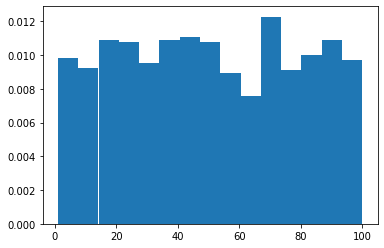

In [358]:
count, bins, ignored = plt.hist(s, 15, normed=True)

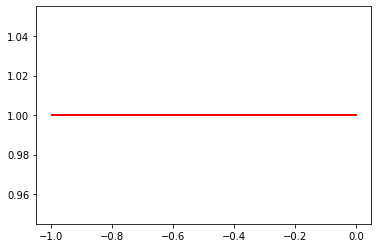

In [356]:
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')

In [363]:
s = np.random.uniform(0,1,10)

In [364]:
for i in 

array([0.60340592, 0.54228601, 0.04163108, 0.4894782 , 0.88065487,
       0.20663055, 0.55519701, 0.09582701, 0.10128205, 0.96954723])

Text(0, 0.5, '$p$')

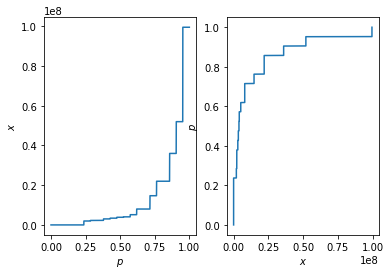

In [402]:
import matplotlib.pyplot as plt
import numpy as np

# create some randomly ddistributed data:
data = csa_206_unk_sampled

# sort the data:
data_sorted = np.sort(data)

# calculate the proportional values of samples
p = 1. * np.arange(len(data)) / (len(data) - 1)

# plot the sorted data:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(p, data_sorted)
ax1.set_xlabel('$p$')
ax1.set_ylabel('$x$')

ax2 = fig.add_subplot(122)
ax2.plot(data_sorted, p)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$p$')

In [7]:
import pandas as pd
import numpy as np
import matplotlib

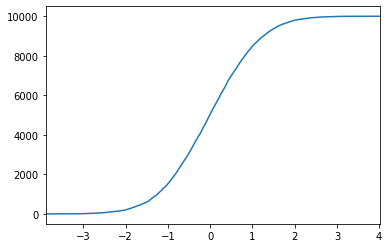

In [19]:
series = pd.Series(np.random.normal(size=10000))

cdf = series.value_counts().sort_index().cumsum()
cdf.plot()

In [13]:
len(cdf) * 0.025

250.0

In [15]:
ax.plot(0.025, 250.0)

NameError: name 'ax' is not defined